In [26]:
import os
import pandas as pd
import numpy as np
import pickle
import glob
import json
from json import JSONDecodeError
import requests
import csv
from collections import Counter,defaultdict
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
reddit_dir = 'reddit_data'

In [3]:
posts_df = pd.read_pickle(os.path.join(reddit_dir,'posts_with_words.pkl'))
posts_df.shape

(975950, 18)

In [4]:
comments_df = pd.read_pickle(os.path.join(reddit_dir,'comments_complete.pkl'))
comments_df.shape

(7991395, 10)

In [17]:
# Exclude rows from bot users
bots = pickle.load(open('bots.pkl','rb'))
print(len(bots))

2805


In [16]:
posts_df = posts_df.loc[~posts_df.author.isin(bots)]
comments_df = comments_df.loc[~comments_df.author.isin(bots)]
print(len(posts_df),len(comments_df))

911496 7945799


In [7]:
annotated_subs = pd.read_csv('most_common_subreddits.tsv',sep='\t',header=0)

In [10]:
#annotated_subs.head()

In [9]:
"""Log-odds computations."""
from math import log, sqrt

def log_odds(c, n):
    """
    log_odds(c1, c2)
    Computes log odds for count data.
    Args:
      c: count of event.
      n: count of all events for the first sample.
    Returns:
      The log odds.
    """
    return log(c) - log(n - c) # log(c/(n-c)); log((c/n)/(1-c/n)) = log(c/(n-c))

def log_odds_ratio(c1, n1, c2, n2):
    """
    log_odds_ratio(c1, n1, c2, n2)
    Computes log odds for two counts.
    Args:
      c1: count of the event in the first sample.
      n1: count of all events for the first sample.
      c2: count in the event in the second sample.
      n1: count of all events for the second sample.
    Returns:
      Log odds.
    """
    return log_odds(c1, n1) - log_odds(c2, n2)

def log_odds_ratio_idp(c1, n1, c2, n2,
                                n3, n4):
    """
    log_odds_ratio_idp(c1, n1, c2, n2, c3, n3)
    Computes log odds ratio with an informative Dirichlet prior, as in:
        Monroe, B. L., Colaresi, M. P. and Quinn, K. M. 2009. Fightin' words:
        Lexical feature selection and evaluation for identifying the content of
        political conflict. Political Analysis 16: 372-403.
    Args:
      c1: count of the event ('claim' introducing opp. statement) in the L-wing.
      n1: count of all events ('claim' introducing statement) for L_wing.
      c2: count of the event ('claim' introducing opp. statement) in the R-wing.
      n2: count of all events ('claim' introducing statement) for R-wing.
      n3: count of all events ('claim' introducing statement) in the third (i.e., the prior) sample (L-wing, other).
      n4: count of all events ('claim' introducing statement) in the third (i.e., the prior) sample (R-wing, other).
    Returns:
      Weighted log odds.
    """
    c1p = c1# + c3
    c2p = c2# + c3
    numerator = log(c1p / (n1 + n3)) - log(c2p / (n2 + n4))
    sigma = sqrt(1. / c1p + 1. / c2p)
    return numerator / sigma

Log odds analyses (overall, by engagement, by stance)
1. try length as engagement signal first (then others)
1. apply other potential categories to data comparisons (e.g. whether original post mentions climate change)

TO DO:
1. get all comments associated with each post
1. X = processed text of post, Y = length of comment thread

Need to set bounds for long and short comment-thread posts:

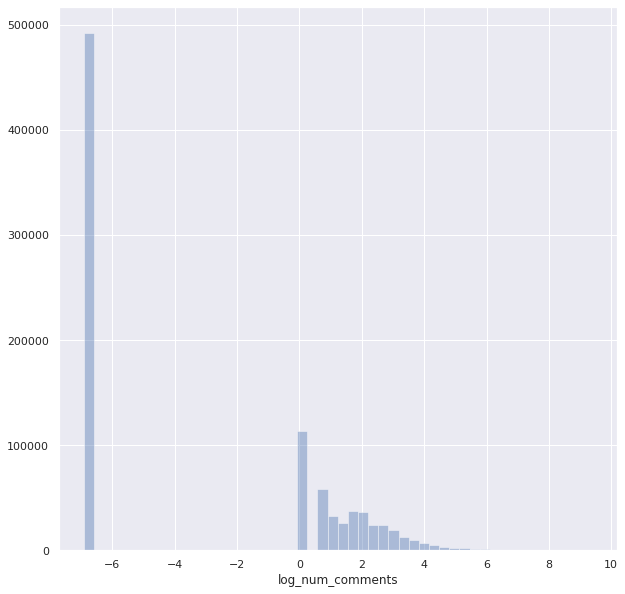

In [27]:
%matplotlib inline
posts_df['log_num_comments'] = posts_df['num_comments'].apply(lambda x: np.log(x+0.001))
fig, ax = plt.subplots(figsize=(10, 10))
sns.distplot(posts_df['log_num_comments'],
                 kde=False, ax=ax)

In [41]:
def partition_lo_hi_posts(posts_,metric_,lo_thresh,hi_thresh):
    
    lo_posts = posts_.loc[posts_[metric_] <= lo_thresh]
    hi_posts = posts_.loc[posts_[metric_] >= hi_thresh]
    
    print('Partitioning {} posts according to {} as engagement metric...'.format(len(posts_),metric_))
    print('Number of low engagement posts:',len(lo_posts))
    print('Number of high engagement posts:',len(hi_posts))
    
    return {'lo':lo_posts,'hi':hi_posts}

In [38]:
mean_log_num_comments = posts_df['log_num_comments'].mean()
std_log_num_comments = posts_df['log_num_comments'].std()
posts_df['log_num_comments'].mean(),posts_df['log_num_comments'].std()

(-3.0413485077295737, 4.292253755996746)

In [40]:
LO_THRESH = mean_log_num_comments-0.5*std_log_num_comments
HI_THRESH = mean_log_num_comments+0.5*std_log_num_comments
LOW_THRESH,HI_THRESH

(-5.1874753857279465, -0.8952216297312008)

In [42]:
partition = partition_lo_hi_posts(posts_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 911496 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 492396
Number of high engagement posts: 419100


In [70]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()


def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def get_lemmas(x):
    
    if len(x) > 0:
        return json.dumps([lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w.lower())) 
                       for w in nltk.word_tokenize(x)])
    return None

In [71]:
json.loads(get_lemmas(posts_df.iloc[100]['title']))

['neighbor', 'wary', 'of', 'giant', 'methane', 'bubble']

In [ ]:
posts_df['title_lemmas'] = posts_df.title.apply(get_lemmas)
posts_df['body_lemmas'] = posts_df.text.apply(get_lemmas)

In [69]:
posts_df['title_lemmas'].apply(lambda x: type(x)).value_counts()

0        681742
9        112004
47          324
94          280
104         231
          ...  
7278          1
5231          1
21729         1
9966          1
12651         1
Name: text, Length: 5707, dtype: int64

In [53]:
posts_df['body_lemmas'].apply(lambda x: type(x)).value_counts()

,id,title,url,author,score,date,num_comments,permalink,flair,is_video,upvote_ratio,text,subreddit,title_num_words,body_num_words,total_num_words,parsed_date,year,log_num_comments
5,anbg0,Scientists have uncovered what appears to be a...,http://news.bbc.co.uk/1/hi/sci/tech/8437703.stm,gIowingsheep,34,2010-01-08 16:40:15,3,/r/environment/comments/anbg0/scientists_have_...,NaN,False,None,,environment,24,0,24,2010-01-08 16:40:15,2010,1.098946
5,akiks,Australia’s Rudd Stands by Call for Action on ...,http://www.greencitizens.net/news/article.php?...,SukhmeetSehgal,1,2010-01-01 08:56:56,1,/r/environment/comments/akiks/australias_rudd_...,NaN,False,None,,environment,10,0,10,2010-01-01 08:56:56,2010,0.001000
5,aos5o,Carbon Debt: Turns out it takes a lot of fossi...,http://climatecentral.org/videos/web_features/...,ClimateCentral,2,2010-01-12 14:31:35,2,/r/science/comments/aos5o/carbon_debt_turns_ou...,NaN,False,None,,science,30,0,30,2010-01-12 14:31:35,2010,0.693647
5,aknp0,"On issues like global warming and evolution, s...",http://www.washingtonpost.com/wp-dyn/content/a...,gst,3,2010-01-01 21:20:00,32,/r/climateskeptics/comments/aknp0/on_issues_li...,NaN,False,None,,climateskeptics,12,0,12,2010-01-01 21:20:00,2010,3.465767
5,aks2h,No rise of atmospheric carbon dioxide fraction...,http://www.sciencedaily.com/releases/2009/12/0...,[deleted],107,2010-01-02 08:26:07,249,/r/science/comments/aks2h/no_rise_of_atmospher...,NaN,False,None,,science,14,0,14,2010-01-02 08:26:07,2010,5.517457
5,3zegnm,Even tumbling fossil fuel prices can't deter c...,http://www.commondreams.org/news/2016/01/01/ev...,madazzahatter,14,2016-01-04 06:39:55,1,/r/environment/comments/3zegnm/even_tumbling_f...,NaN,None,None,,environment,32,0,32,2016-01-04 06:39:55,2016,0.001000
5,3z0yfl,Big Oil braced for global warming while it fou...,http://graphics.latimes.com/oil-operations/,RIPmod,3,2016-01-01 10:54:03,1,/r/RIPworldnews/comments/3z0yfl/big_oil_braced...,NaN,None,None,,RIPworldnews,10,0,10,2016-01-01 10:54:03,2016,0.001000
5,3zvyq0,[Serious] For German Redditors or those curren...,https://www.reddit.com/r/AskReddit/comments/3z...,[deleted],0,2016-01-07 10:37:56,3,/r/AskReddit/comments/3zvyq0/serious_for_germa...,serious replies only,None,None,[deleted],AskReddit,23,1,24,2016-01-07 10:37:56,2016,1.098946
5,eier90,Ryzen 5 2600 and msi b450 carbon ac or a ryzen...,https://www.reddit.com/r/gamingpc/comments/eie...,Jxckon,1,2020-01-01 00:50:05,2,/r/gamingpc/comments/eier90/ryzen_5_2600_and_m...,NaN,False,NaN,[removed],gamingpc,20,1,21,2020-01-01 00:50:05,2020,0.693647
5,eimv7z,A Fracking Explosion In Ohio Created One Of Wo...,https://radio.wosu.org/post/fracking-explosion...,readerseven,1,2020-01-01 14:57:37,103,/r/TechNewsToday/comments/eimv7z/a_fracking_ex...,NaN,False,NaN,,TechNewsToday,13,0,13,2020-01-01 14:57:37,2020,4.634739


In [52]:
partition['hi']

,id,title,url,author,score,date,num_comments,permalink,flair,is_video,upvote_ratio,text,subreddit,title_num_words,body_num_words,total_num_words,parsed_date,year,log_num_comments
5,anbg0,Scientists have uncovered what appears to be a...,http://news.bbc.co.uk/1/hi/sci/tech/8437703.stm,gIowingsheep,34,2010-01-08 16:40:15,3,/r/environment/comments/anbg0/scientists_have_...,NaN,False,None,,environment,24,0,24,2010-01-08 16:40:15,2010,1.098946
7,apn8b,BBC News - Methane release 'looks stronger',http://news.bbc.co.uk/2/hi/science/nature/8437...,twinspop,13,2010-01-14 12:59:24,2,/r/environment/comments/apn8b/bbc_news_methane...,NaN,False,None,,environment,7,0,7,2010-01-14 12:59:24,2010,0.693647
8,aprgq,Arctic permafrost leaking methane at record le...,http://www.guardian.co.uk/environment/2010/jan...,BlueRock,21,2010-01-14 18:49:13,8,/r/environment/comments/aprgq/arctic_permafros...,NaN,False,None,,environment,28,0,28,2010-01-14 18:49:13,2010,2.079567
9,aprgv,Arctic permafrost leaking methane at record le...,http://www.guardian.co.uk/environment/2010/jan...,BlueRock,27,2010-01-14 18:49:26,10,/r/science/comments/aprgv/arctic_permafrost_le...,NaN,False,None,,science,28,0,28,2010-01-14 18:49:26,2010,2.302685
10,aprie,Arctic permafrost leaking methane at record le...,http://www.guardian.co.uk/environment/2010/jan...,spainguy,21,2010-01-14 18:53:52,4,/r/worldnews/comments/aprie/arctic_permafrost_...,NaN,False,None,,worldnews,9,0,9,2010-01-14 18:53:52,2010,1.386544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30167,3yuldj,Clinton bashes Republicans in 'denial' about c...,http://www.msn.com/en-us/news/politics/clinton...,catsdigme,2,2015-12-30 19:14:40,3,/r/politics/comments/3yuldj/clinton_bashes_rep...,NaN,None,None,,politics,8,0,8,2015-12-30 19:14:40,2015,1.098946
30168,3yulsl,NASA: Worst of El Nino Still to Come. With Cli...,http://robertscribbler.com/2015/12/30/nasa-wor...,GarryRogers,0,2015-12-30 19:17:53,2,/r/NatureConservation/comments/3yulsl/nasa_wor...,NaN,None,None,,NatureConservation,22,0,22,2015-12-30 19:17:53,2015,0.693647
30169,3yup0j,NASA: Worst of El Nino Still to Come. With Cli...,http://robertscribbler.com/2015/12/30/nasa-wor...,DarthHarper,43,2015-12-30 19:42:12,2,/r/climate/comments/3yup0j/nasa_worst_of_el_ni...,NaN,None,None,,climate,22,0,22,2015-12-30 19:42:12,2015,0.693647
30171,3yuytd,Judith Curry: Unnatural consensus on climate c...,http://business.financialpost.com/fp-comment/u...,logicalprogressive,16,2015-12-30 21:00:19,50,/r/climateskeptics/comments/3yuytd/judith_curr...,NaN,None,None,,climateskeptics,7,0,7,2015-12-30 21:00:19,2015,3.912043
